In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid", rc={"figure.figsize": (8, 6)})


In [2]:
df = pd.read_csv("Mall_Customers.csv")
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nDescribe:")
print(df.describe(include='all'))


Shape: (200, 5)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Describe:
        CustomerID  Gender         Age  Annual Income (k$)  \
count   200.000000     200  200.000000          200.000000   
unique         NaN       2         NaN                 NaN   
top            NaN  Female         NaN                 NaN   
freq           NaN     112         NaN                 NaN   
mean    100.500000     NaN   38.850000           60.560000   
std      57.879185     NaN   13.969007           26.264721   
min      

In [4]:
# Auto-detect column names
cols = df.columns.str.lower()

age_col = [c for c in df.columns if "age" in c.lower()][0]
income_col = [c for c in df.columns if "income" in c.lower()][0]
spend_col = [c for c in df.columns if "spending" in c.lower() or "score" in c.lower()][0]

X = df[[age_col, income_col, spend_col]].copy()
X.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [5]:
X = X.fillna(X.median())
X.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

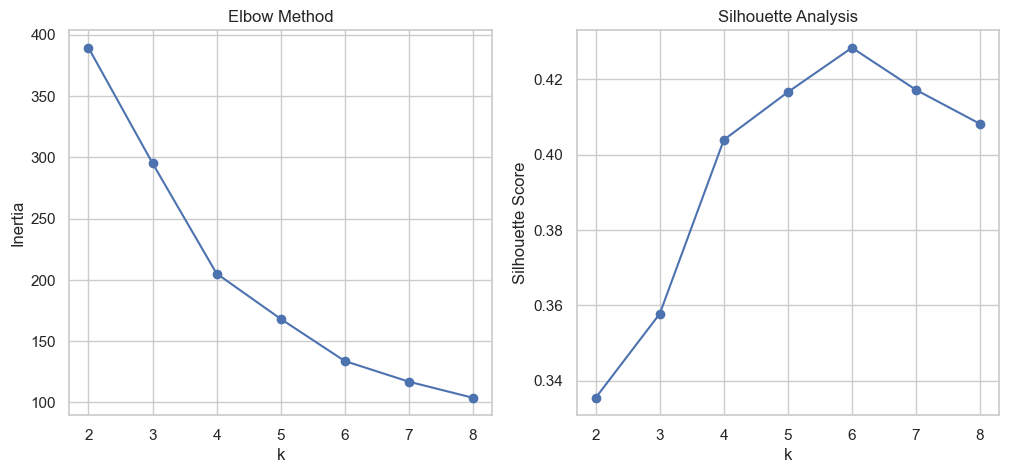

6

In [7]:
distortions = []
sil_scores = []
K = range(2, 9)

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    preds = model.fit_predict(X_scaled)
    distortions.append(model.inertia_)
    sil_scores.append(silhouette_score(X_scaled, preds))

plt.figure(figsize=(12,5))

# Elbow Curve
plt.subplot(1,2,1)
plt.plot(K, distortions, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Silhouette Curve
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")

plt.show()

best_k = K[np.argmax(sil_scores)]
best_k


In [8]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

df["Cluster"] = labels
df.head()


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster
0,1,Male,19,15,39,4
1,2,Male,21,15,81,4
2,3,Female,20,16,6,5
3,4,Female,23,16,77,4
4,5,Female,31,17,40,5


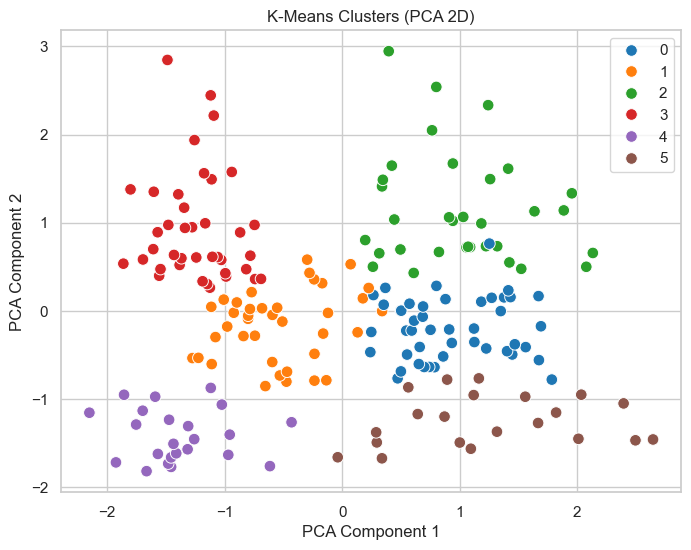

In [9]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette="tab10", s=70)
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [10]:
cluster_means = df.groupby("Cluster")[[income_col, spend_col]].mean()
cluster_means


,Annual Income (k$),Spending Score (1-100)
Cluster,,
0,54.266667,49.066667
1,57.102564,48.128205
2,88.939394,16.969697
3,86.538462,82.128205
4,25.260870,77.608696
5,26.285714,19.380952


In [11]:
# Rank clusters by spending score
order = cluster_means[spend_col].sort_values().index.tolist()

names = {}
if len(order) == 3:
    labels_map = ["Low Spenders", "Medium Spenders", "High Spenders"]
    for i, cid in enumerate(order):
        names[cid] = labels_map[i]
else:
    # fallback for more clusters
    for i, cid in enumerate(order):
        names[cid] = f"Group {i}"

df["Cluster_Name"] = df["Cluster"].map(names)
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Cluster,Cluster_Name
0,1,Male,19,15,39,4,Group 4
1,2,Male,21,15,81,4,Group 4
2,3,Female,20,16,6,5,Group 1
3,4,Female,23,16,77,4,Group 4
4,5,Female,31,17,40,5,Group 1


In [12]:
df.to_csv("Mall_Customers_Clustered.csv", index=False)
print("Saved as Mall_Customers_Clustered.csv")


Saved as Mall_Customers_Clustered.csv
